In [1]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # This provides a nice progress bar
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModel

In [2]:
# !python -m spacy download en_core_web_sm

In [3]:
# Loading SpaCy English Models
nlp = spacy.load("en_core_web_sm")
# Enabling tqdm support on pandas
tqdm.pandas()

In [4]:
# Functions for loading datasets
def load_dataset(file_path):
    """
    This function loads a dataset from a JSON file.

    Args:
    file_path (str): The path to the JSON file.

    Returns:
    DataFrame: A pandas DataFrame containing the dataset.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    df = pd.DataFrame([{
        'question': item['question'],
        'option1': item['options'][0],
        'option2': item['options'][1],
        'option3': item['options'][2],
        'option4': item['options'][3],
        'correct_index': item['correct_index'] + 1
    } for item in data])

    return df

In [5]:
df_train = load_dataset('wikiqa_coursework_dataset/coursework_dataset/train.json')
df_val = load_dataset('wikiqa_coursework_dataset/coursework_dataset/val.json')
df_test = load_dataset('wikiqa_coursework_dataset/coursework_dataset/test.json')

# Q1 

In [6]:
def text_pipeline_spacy_special(text):
    """
    This function tokenizes the text using SpaCy.
    It removes punctuation and spaces, and converts all text to lowercase.
    
    Args:
    text (str): The text to be tokenized.
    
    Returns:
    list: A list of tokens.
    """
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_punct and not t.is_space:
            tokens.append(t.text.lower())
    return tokens

In [7]:
def token_data(df, dataset_name="Dataset"):
    """
    This function tokenizes the questions and options in a dataset.

    Args:
    df (DataFrame): The dataset to be tokenized.
    dataset_name (str): The name of the dataset.

    Returns:
    DataFrame: A pandas DataFrame containing the tokenized dataset.
    """
    print(f'-------- {dataset_name} --------')
    print('Tokenizing questions...')
    df['questions_tokens'] = df['question'].progress_apply(text_pipeline_spacy_special)
    print('Tokenizing options...')
    for i in range(1, 5):
        df[f'option{i}_tokens'] = df[f'option{i}'].progress_apply(text_pipeline_spacy_special)
    df['correct_options_tokens'] = df.apply(lambda row: row[f'option{row["correct_index"]}_tokens'], axis=1)

    df_token = pd.DataFrame({
        'questions_tokens': df['questions_tokens'],
        'option1_tokens': df['option1_tokens'],
        'option2_tokens': df['option2_tokens'],
        'option3_tokens': df['option3_tokens'],
        'option4_tokens': df['option4_tokens'],
        'correct_options_tokens': df['correct_options_tokens'],
        'correct_index': df['correct_index']
    })

    return df_token

In [8]:
def print_df_info(df_token, dataset_name="Dataset"):
    """
    This function prints information about a dataset, including the total number of questions and options,
    the average length of questions, options, and correct options.

    Args:
    df_token (DataFrame): The dataset to be analyzed.
    dataset_name (str): The name of the dataset.
    """
    print(f'-------- {dataset_name} --------')
    print(f'Total questions: {len(df_token)}')
    print(f'Total options: {len(df_token) * 4}')
    print(f"Average question length: {df_token['questions_tokens'].apply(len).mean()}")
    print(
        f'Average option length: {df_token[[f"option{i}_tokens" for i in range(1, 5)]].apply(lambda x: x.map(len)).mean().mean()}')
    print(f'Average correct option length: {df_token["correct_options_tokens"].apply(len).mean()}')

In [9]:
df_token_train = token_data(df_train, dataset_name="Training Data")
df_token_val = token_data(df_val, dataset_name="Validation Data")
df_token_test = token_data(df_test, dataset_name="Test Data")

-------- Training Data --------
Tokenizing questions...


100%|██████████| 741/741 [00:01<00:00, 381.98it/s]


Tokenizing options...


100%|██████████| 741/741 [00:03<00:00, 240.27it/s]


-------- Validation Data --------
Tokenizing questions...


100%|██████████| 103/103 [00:00<00:00, 367.76it/s]


Tokenizing options...


100%|██████████| 103/103 [00:00<00:00, 230.40it/s]


-------- Test Data --------
Tokenizing questions...


100%|██████████| 202/202 [00:00<00:00, 384.17it/s]


Tokenizing options...


100%|██████████| 202/202 [00:00<00:00, 231.70it/s]


In [10]:
df_token_train

,questions_tokens,option1_tokens,option2_tokens,option3_tokens,option4_tokens,correct_options_tokens,correct_index
0,"[how, are, glacier, caves, formed]","[the, ice, facade, is, approximately, 60, m, h...","[a, partly, submerged, glacier, cave, on, peri...","[ice, formations, in, the, titlis, glacier, cave]","[a, glacier, cave, is, a, cave, formed, within...","[a, glacier, cave, is, a, cave, formed, within...",4
1,"[how, much, is, 1, tablespoon, of, water]","[in, the, uk, europe, and, most, commonwealth,...","[in, the, us, and, parts, of, canada, a, table...","[this, tablespoon, has, a, capacity, of, about...","[measuring, spoons]","[this, tablespoon, has, a, capacity, of, about...",3
2,"[how, much, are, the, harry, potter, movies, w...","[harry, potter, is, a, series, of, seven, fant...","[the, main, story, arc, concerns, harry, 's, q...","[the, books, chronicle, the, adventures, of, a...","[the, series, also, originated, much, tie, in,...","[the, series, also, originated, much, tie, in,...",4
3,"[how, a, rocket, engine, works]","[rs-68, being, tested, at, nasa, 's, stennis, ...","[the, nearly, transparent, exhaust, is, due, t...","[a, rocket, engine, or, simply, rocket, is, a,...","[viking, 5c, rocket, engine]","[a, rocket, engine, or, simply, rocket, is, a,...",3
4,"[how, are, cholera, and, typhus, transmitted, ...","[cholera, is, an, infection, in, the, small, i...","[the, main, symptoms, are, watery, diarrhea, a...","[the, severity, of, the, diarrhea, and, vomiti...","[transmission, occurs, primarily, by, drinking...","[transmission, occurs, primarily, by, drinking...",4
...,...,...,...,...,...,...,...
736,"[what, is, melissa, and, joey, about]","[the, series, follows, local, politician, mel,...","[melissa, joey, is, an, abc, family, original,...","[it, first, aired, on, abc, family, on, august...","[the, series, was, renewed, by, abc, family, f...","[the, series, follows, local, politician, mel,...",1
737,"[what, is, an, economic, feature]","[economics, is, the, social, science, that, an...","[the, term, economics, comes, from, the, ancie...","[other, broad, distinctions, include, those, b...","[political, economy, was, the, earlier, name, ...","[other, broad, distinctions, include, those, b...",3
738,"[what, is, the, average, american, income]","[median, us, household, income, 2001, 2011]","[u.s., median, household, income, fell, from, ...","[us, county, household, median, income, 2009]","[household, income, is, a, measure, commonly, ...","[u.s., median, household, income, fell, from, ...",2
739,"[when, was, apple, computer, founded]","[apple, inc., formerly, apple, computer, inc.,...","[its, software, includes, the, os, x, and, ios...","[the, company, was, founded, on, april, 1, 197...","[its, best, known, hardware, products, are, th...","[the, company, was, founded, on, april, 1, 197...",3


In [11]:
df_token_val

,questions_tokens,option1_tokens,option2_tokens,option3_tokens,option4_tokens,correct_options_tokens,correct_index
0,"[how, big, is, bmc, software, in, houston, tx]","[headquartered, in, houston, texas, bmc, devel...","[bmc, software, inc., is, an, american, compan...","[the, name, bmc, is, taken, from, the, surname...","[employing, over, 6,000, bmc, is, often, credi...","[employing, over, 6,000, bmc, is, often, credi...",4
1,"[how, long, was, i, love, lucy, on, the, air]","[i, love, lucy, was, the, most, watched, show,...","[after, the, series, ended, in, 1957, however,...","[the, black, and, white, series, originally, r...","[i, love, lucy, is, an, american, television, ...","[the, black, and, white, series, originally, r...",3
2,"[how, did, armando, christian, perez, become, ...","[his, first, recorded, performance, was, from,...","[since, then, he, has, released, three, other,...","[in, 2004, he, released, his, debut, album, ti...","[armando, pérez, born, january, 15, 1981, bett...","[armando, pérez, born, january, 15, 1981, bett...",4
3,"[what, bird, family, is, the, owl]","[most, are, solitary, and, nocturnal, with, so...","[owls, hunt, mostly, small, mammals, insects, ...","[owls, are, a, group, of, birds, that, belong,...","[they, are, found, in, all, regions, of, the, ...","[owls, are, a, group, of, birds, that, belong,...",3
4,"[how, many, people, were, killed, in, the, okl...","[the, oklahoma, city, bombing, was, a, domesti...","[it, would, remain, the, most, destructive, ac...","[the, blast, destroyed, or, damaged, 324, buil...","[the, oklahoma, blast, claimed, 168, lives, in...","[the, oklahoma, blast, claimed, 168, lives, in...",4
...,...,...,...,...,...,...,...
98,"[who, is, the, highest, scoring, nba, player]","[the, national, basketball, association, 's, n...","[michael, jordan, has, won, ten, scoring, titl...","[wilt, chamberlain, holds, the, all, time, rec...","[in, basketball, points, are, the, sum, of, th...","[wilt, chamberlain, holds, the, all, time, rec...",3
99,"[what, is, direct, marketing, channel]","[characteristics, that, distinguish, direct, m...","[direct, marketing, messages, emphasize, a, fo...","[marketing, messages, are, addressed, directly...","[direct, marketing, is, a, channel, agnostic, ...","[direct, marketing, is, a, channel, agnostic, ...",4
100,"[what, is, disney, 's, magic, kingdom]","[in, 2011, the, park, hosted, approximately, 1...","[it, opened, on, october, 1, 1971]","[magic, kingdom, park, also, known, as, magic,...","[designed, and, built, by, wed, enterprises, i...","[magic, kingdom, park, also, known, as, magic,...",3
101,"[what, is, the, name, of, the, family, who, ow...","[biltmore, estate, is, a, large, private, esta...","[still, owned, by, one, of, vanderbilt, 's, de...","[in, 2007, it, was, ranked, eighth, in, americ...","[biltmore, house, the, main, house, on, the, e...","[still, owned, by, one, of, vanderbilt, 's, de...",2


In [12]:
df_token_test

,questions_tokens,option1_tokens,option2_tokens,option3_tokens,option4_tokens,correct_options_tokens,correct_index
0,"[how, african, americans, were, immigrated, to...","[the, term, african, in, the, scope, of, this,...","[african, immigration, to, the, united, states...","[from, the, immigration, and, nationality, act...","[as, such, african, immigrants, are, to, be, d...","[as, such, african, immigrants, are, to, be, d...",4
1,"[how, a, water, pump, works]","[a, pump, is, a, device, that, moves, fluids, ...","[a, large, electrically, driven, pump, electro...","[pumps, operate, by, some, mechanism, typicall...","[a, small, electrically, powered, pump]","[pumps, operate, by, some, mechanism, typicall...",3
2,"[how, old, was, sue, lyon, when, she, made, lo...","[lolita, is, a, 1962, comedy, drama, film, by,...","[due, to, the, mpaa, 's, restrictions, at, the...","[the, film, stars, james, mason, as, humbert, ...","[the, actress, who, played, lolita, sue, lyon,...","[the, actress, who, played, lolita, sue, lyon,...",4
3,"[how, are, antibodies, used, in]","[each, antibody, binds, to, a, specific, antig...","[the, production, of, antibodies, is, the, mai...","[an, antibody, ab, also, known, as, an, immuno...","[antibodies, are, secreted, by, a, type, of, w...","[an, antibody, ab, also, known, as, an, immuno...",3
4,"[how, much, is, centavos, in, mexico]","[the, peso, sign, $, code, mxn, is, the, curre...","[modern, peso, and, dollar, currencies, have, ...","[the, mexican, peso, is, the, 13th, most, trad...","[the, peso, is, subdivided, into, 100, centavo...","[the, peso, is, subdivided, into, 100, centavo...",4
...,...,...,...,...,...,...,...
197,"[what, is, the, latest, season, of, psych]","[psych, is, an, american, detective, comedy, d...","[the, series, stars, james, roday, as, shawn, ...","[it, is, produced, by, franks, and, tagline, t...","[psych, began, its, seventh, season, on, febru...","[psych, began, its, seventh, season, on, febru...",4
198,"[what, is, the, main, component, of, vaccines]","[a, vaccine, is, a, biological, preparation, t...","[a, vaccine, typically, contains, an, agent, t...","[the, agent, stimulates, the, body, 's, immune...","[jonas, salk, in, 1955, holds, two, bottles, o...","[the, agent, stimulates, the, body, 's, immune...",3
199,"[who, are, all, of, the, jonas, brothers]","[the, jonas, brothers, are, an, american, pop,...","[brothers, also, starring, in, tv, series, dis...","[in, the, summer, of, 2008, they, starred, in,...","[formed, in, 2005, they, have, gained, popular...","[formed, in, 2005, they, have, gained, popular...",4
200,"[who, is, mary, matalin, married, to]","[she, is, married, to, democratic, political, ...","[this, is, about, the, political, professional]","[for, the, actress, see, marlee, matlin]","[mary, joe, matalin, born, august, 19, 1953, i...","[she, is, married, to, democratic, political, ...",1


In [13]:
# Print analysis results
print_df_info(df_token_train)
print_df_info(df_token_val)
print_df_info(df_token_test)


-------- Dataset --------
Total questions: 741
Total options: 2964
Average question length: 6.272604588394062
Average option length: 22.33805668016194
Average correct option length: 26.032388663967613
-------- Dataset --------
Total questions: 103
Total options: 412
Average question length: 6.466019417475728
Average option length: 21.2742718446602
Average correct option length: 25.25242718446602
-------- Dataset --------
Total questions: 202
Total options: 808
Average question length: 6.366336633663367
Average option length: 21.74876237623762
Average correct option length: 24.405940594059405


## 1.1 How many questions and options are there in each split? [1 mark]

|                 | Training Data | Validation Data | Test Data |
|-----------------|---------------|-----------------|-----------|
| total_questions | 741           | 103             | 202       |
| total_options   | 2964          | 412             | 808       | 

## 1.2 What is the average number of tokens per question in the training set? [1 mark]
- According to the project output, the training set had an average of 6.2726 tokens in the problem
## 1.3 What is the average number of tokens per choice in the training set? [1 mark]
- According to the project output, the training set had an average of 22.3381 tokens in the options
## 1.4 What is the average number of tokens per correct choice in the training set? [1 mark]
- According to the project output, the training set had an average of 26.0324 tokens in the correct options

In [14]:
def plot_length_distributions(df, dataset_name, axs):
    """
    This function plots the length distributions of questions, options, and correct options in a dataset.

    Args:
    df (DataFrame): The dataset to be analyzed.
    dataset_name (str): The name of the dataset.
    axs (matplotlib.axes.Axes): The axes on which to plot the distributions.
    """
    questions_lengths = df['questions_tokens'].str.len()
    options_lengths = df[[f'option{i}_tokens' for i in range(1, 5)]].apply(lambda x: x.str.len()).values.flatten()
    correct_option_lengths = df['correct_options_tokens'].str.len()

    axs[0].hist(questions_lengths, bins=20)
    axs[0].set_title(f'Question Lengths in {dataset_name}')
    axs[0].set_xlabel('Question Length')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(options_lengths, bins=20)
    axs[1].set_title(f'Option Lengths in {dataset_name}')
    axs[1].set_xlabel('Option Length')
    axs[1].set_ylabel('Frequency')

    axs[2].hist(correct_option_lengths, bins=20)
    axs[2].set_title(f'Correct Option Lengths in {dataset_name}')
    axs[2].set_xlabel('Correct Option Length')
    axs[2].set_ylabel('Frequency')

In [15]:
def plot_data_distributions(df_1, df_2, df_3):
    """
    This function plots the data distributions of three datasets.

    Args:
    df_1 (DataFrame): The Train dataset to be plotted.
    df_2 (DataFrame): The Validation  dataset to be plotted.
    df_3 (DataFrame): The Test dataset to be plotted.
    """
    # Create a figure with 9 subplots
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    # Plot length distributions for training data
    plot_length_distributions(df_1, dataset_name="Training Data", axs=axs[:, 0])

    # Plot length distributions for validation data
    plot_length_distributions(df_2, dataset_name="Validation Data", axs=axs[:, 1])

    # Plot length distributions for test data
    plot_length_distributions(df_3, dataset_name="Test Data", axs=axs[:, 2])

    plt.tight_layout()
    plt.savefig('length_distributions.png')
    plt.show()

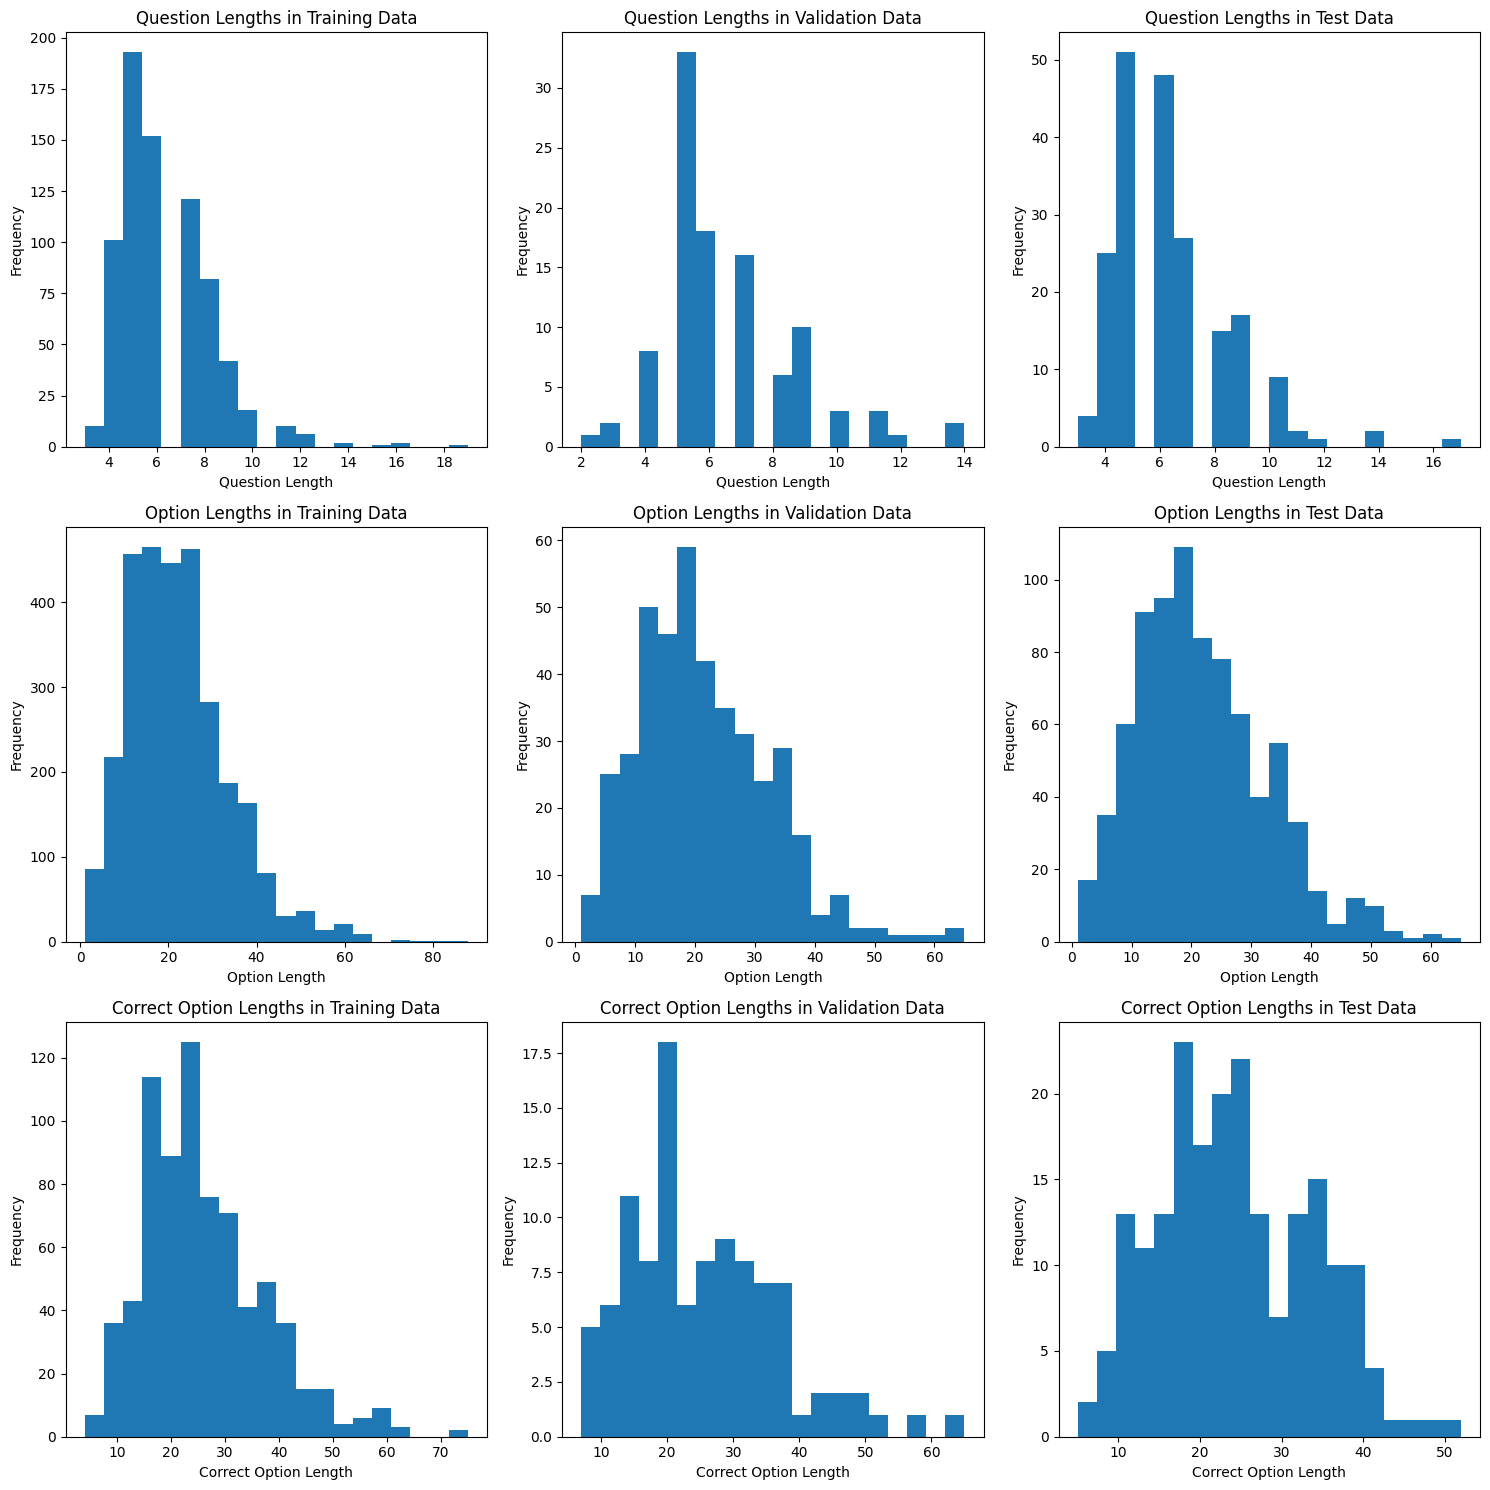

In [16]:
plot_data_distributions(df_token_train, df_token_val, df_token_test)

In [17]:
def count_top_words(df, top_n=10, dataset_name="Dataset"):
    """
    This function counts the top n most frequent words in a dataset.

    Args:
    df (DataFrame): The dataset to be analyzed.
    top_n (int): The number of top words to count.
    dataset_name (str): The name of the dataset.

    Returns:
    DataFrame: A pandas DataFrame containing the top n most frequent words and their frequencies.
    """
    question_words = [word for tokens in df['questions_tokens'] for word in tokens]
    option_words = [word for tokens in
                    df[['option1_tokens', 'option2_tokens', 'option3_tokens', 'option4_tokens']].apply(
                        lambda x: x.iloc[0] + x.iloc[1] + x.iloc[2] + x.iloc[3], axis=1) for word in tokens]
    correct_option_words = [word for tokens in df['correct_options_tokens'] for word in tokens]

    count_question_words = Counter(question_words)
    count_option_words = Counter(option_words)
    count_correct_options_words = Counter(correct_option_words)

    print(f'-------- {dataset_name} --------')
    print('Most common words in questions:', count_question_words.most_common(top_n))
    print('Most common words in options:', count_option_words.most_common(top_n))
    print('Most common words in correct options:', count_correct_options_words.most_common(top_n))

    return count_question_words, count_option_words, count_correct_options_words

In [18]:
_ = count_top_words(df_token_train, 10, dataset_name="Training Data")
_ = count_top_words(df_token_val, 10, dataset_name="Validation Data")
_ = count_top_words(df_token_test, 10, dataset_name="Test Data")

-------- Training Data --------
Most common words in questions: [('what', 392), ('is', 304), ('the', 254), ('in', 130), ('how', 116), ('who', 101), ('of', 94), ('a', 91), ('when', 81), ('are', 72)]
Most common words in options: [('the', 5020), ('of', 2577), ('and', 2078), ('in', 1754), ('a', 1705), ('is', 1331), ('to', 1086), ('as', 715), ('by', 614), ('or', 497)]
Most common words in correct options: [('the', 1366), ('of', 736), ('and', 604), ('a', 571), ('in', 528), ('is', 458), ('to', 285), ('by', 210), ('as', 197), ('or', 180)]
-------- Validation Data --------
Most common words in questions: [('what', 60), ('the', 50), ('is', 40), ('are', 16), ('of', 16), ('in', 15), ('was', 13), ('on', 12), ('who', 12), ('where', 12)]
Most common words in options: [('the', 641), ('of', 310), ('and', 261), ('in', 251), ('a', 216), ('is', 166), ('to', 141), ('as', 102), ('was', 83), ('by', 70)]
Most common words in correct options: [('the', 183), ('of', 91), ('a', 78), ('and', 72), ('in', 69), ('is

## 1.5 Perform any additional exploration of the data that you feel would be helpful for this multiple-choice question-answering task. Briefly describe what you found. [4 marks]
- From the output above, we can see the length distribution of questions and options in each dataset. 
- We can see that most of the length distributions of questions are below 10 tokens, most of the length distributions of options are below 40 tokens, and most of the length distributions of correct options are below 50 tokens.
- This information is useful for limiting the length of inputs when we design our models.
- We can also see the most common words in each dataset. 
- These words may be deactivated words, and we may consider removing them in the preprocessing step. 
- In addition, we can see the most common words in the correct options, which may be keywords that our model needs to focus on.

# Q2

In [19]:
def calculate_similarity_scores(question, options):
    """
    This function calculates the similarity scores between a question and a list of options.
    similarity scores are calculated using the overlap coefficient, Sorensen-Dice coefficient, and Jaccard coefficient.

    Args:
    question (str): The question to be compared.
    options (list): The list of options to be compared.

    Returns:
    list: A list of similarity scores.
    """
    question_set = set(question)
    scores = []
    for option in options:
        option_set = set(option)

        overlap = len(question_set & option_set) / min(len(question_set), len(option_set))
        sorensen_dice = 2 * len(question_set & option_set) / (len(question_set) + len(option_set))
        jaccard = len(question_set & option_set) / len(question_set | option_set)

        scores.append((overlap, sorensen_dice, jaccard))
    return scores

In [20]:
def calculate_accuracy(df):
    """
    This function calculates the accuracy of a model on a dataset.
    The model selects the option with the highest similarity score as the answer.

    Args:
    df (DataFrame): The dataset to be evaluated.

    Returns:
    float: The accuracy of the model.
    """
    correct_overlap = 0
    correct_sorensen_dice = 0
    correct_jaccard = 0
    scores_list = []
    for idx, row in df.iterrows():
        question = row['questions_tokens']
        options = [row[f'option{i}_tokens'] for i in range(1, 5)]
        scores = calculate_similarity_scores(question, options)
        scores_list.append(scores)
        chosen_overlap = np.argmax([score[0] for score in scores])  # selects the option with the highest overlap score
        chosen_sorensen_dice = np.argmax(
            [score[1] for score in scores])  # selects the option with the highest Sorensen-Dice score
        chosen_jaccard = np.argmax([score[2] for score in scores])  # Select the option with the highest Jaccard score
        if chosen_overlap == row['correct_index'] - 1:  # If the overlap score selection is correct
            correct_overlap += 1
        if chosen_sorensen_dice == row['correct_index'] - 1:  # If the Sorensen-Dice choice is correct
            correct_sorensen_dice += 1
        if chosen_jaccard == row['correct_index'] - 1:  # If Jaccard is right.
            correct_jaccard += 1
    df['scores'] = scores_list
    return correct_overlap / len(df), correct_sorensen_dice / len(df), correct_jaccard / len(df), df

In [21]:
train_accuracy = calculate_accuracy(df_token_train)
val_accuracy = calculate_accuracy(df_token_val)

print(
    f'Training:\toverlap: {train_accuracy[0] * 100:.3f}%\tSorensen-Dice: {train_accuracy[1] * 100:.3f}%\tJaccard: {train_accuracy[2] * 100:.3f}%')
print(
    f'Validation:\toverlap: {val_accuracy[0] * 100:.3f}%\tSorensen-Dice: {val_accuracy[1] * 100:.3f}%\tJaccard: {val_accuracy[2] * 100:.3f}%')

Training:	overlap: 52.362%	Sorensen-Dice: 42.915%	Jaccard: 42.915%
Validation:	overlap: 46.602%	Sorensen-Dice: 35.922%	Jaccard: 35.922%


In [22]:
train_accuracy[3]

,questions_tokens,option1_tokens,option2_tokens,option3_tokens,option4_tokens,correct_options_tokens,correct_index,scores
0,"[how, are, glacier, caves, formed]","[the, ice, facade, is, approximately, 60, m, h...","[a, partly, submerged, glacier, cave, on, peri...","[ice, formations, in, the, titlis, glacier, cave]","[a, glacier, cave, is, a, cave, formed, within...","[a, glacier, cave, is, a, cave, formed, within...",4,"[(0.0, 0.0, 0.0), (0.2, 0.15384615384615385, 0..."
1,"[how, much, is, 1, tablespoon, of, water]","[in, the, uk, europe, and, most, commonwealth,...","[in, the, us, and, parts, of, canada, a, table...","[this, tablespoon, has, a, capacity, of, about...","[measuring, spoons]","[this, tablespoon, has, a, capacity, of, about...",3,"[(0.42857142857142855, 0.23076923076923078, 0...."
2,"[how, much, are, the, harry, potter, movies, w...","[harry, potter, is, a, series, of, seven, fant...","[the, main, story, arc, concerns, harry, 's, q...","[the, books, chronicle, the, adventures, of, a...","[the, series, also, originated, much, tie, in,...","[the, series, also, originated, much, tie, in,...",4,"[(0.375, 0.24, 0.13636363636363635), (0.5, 0.1..."
3,"[how, a, rocket, engine, works]","[rs-68, being, tested, at, nasa, 's, stennis, ...","[the, nearly, transparent, exhaust, is, due, t...","[a, rocket, engine, or, simply, rocket, is, a,...","[viking, 5c, rocket, engine]","[a, rocket, engine, or, simply, rocket, is, a,...",3,"[(0.0, 0.0, 0.0), (0.2, 0.07407407407407407, 0..."
4,"[how, are, cholera, and, typhus, transmitted, ...","[cholera, is, an, infection, in, the, small, i...","[the, main, symptoms, are, watery, diarrhea, a...","[the, severity, of, the, diarrhea, and, vomiti...","[transmission, occurs, primarily, by, drinking...","[transmission, occurs, primarily, by, drinking...",4,"[(0.14285714285714285, 0.1, 0.0526315789473684..."
...,...,...,...,...,...,...,...,...
736,"[what, is, melissa, and, joey, about]","[the, series, follows, local, politician, mel,...","[melissa, joey, is, an, abc, family, original,...","[it, first, aired, on, abc, family, on, august...","[the, series, was, renewed, by, abc, family, f...","[the, series, follows, local, politician, mel,...",1,"[(0.5, 0.17142857142857143, 0.09375), (0.66666..."
737,"[what, is, an, economic, feature]","[economics, is, the, social, science, that, an...","[the, term, economics, comes, from, the, ancie...","[other, broad, distinctions, include, those, b...","[political, economy, was, the, earlier, name, ...","[other, broad, distinctions, include, those, b...",3,"[(0.2, 0.10526315789473684, 0.0555555555555555..."
738,"[what, is, the, average, american, income]","[median, us, household, income, 2001, 2011]","[u.s., median, household, income, fell, from, ...","[us, county, household, median, income, 2009]","[household, income, is, a, measure, commonly, ...","[u.s., median, household, income, fell, from, ...",2,"[(0.16666666666666666, 0.16666666666666666, 0...."
739,"[when, was, apple, computer, founded]","[apple, inc., formerly, apple, computer, inc.,...","[its, software, includes, the, os, x, and, ios...","[the, company, was, founded, on, april, 1, 197...","[its, best, known, hardware, products, are, th...","[the, company, was, founded, on, april, 1, 197...",3,"[(0.4, 0.14285714285714285, 0.0769230769230769..."


## 2.1 Report the performance of each similarity measure (overlap coefficient, Sorensen-Dice & Jaccard) on the training and validation sets by measuring accuracy. [6 marks]

|            | Overlap Coefficient | Sorensen-Dice | Jaccard |
|------------|---------------------|---------------|---------|
| Training   | 52.362%             | 42.915%       | 42.915% |
| Validation | 46.602%             | 35.922%       | 35.922% |


In [23]:
def count_ties(df):
    """
    This function counts the number of ties in the similarity scores of a dataset.
    If there are more than 3 ties, they will also be counted as 1.
    
    Args:
    df (DataFrame): The dataset to be analyzed.
    
    Returns:
    int: The number of ties.
    """
    overlap_ties = 0
    sorensen_dice_ties = 0
    jaccard_ties = 0
    for index, scores in enumerate(df['scores']):
        overlap_scores = [score[0] for score in scores]
        sorensen_dice_scores = [score[1] for score in scores]
        jaccard_scores = [score[2] for score in scores]
        if overlap_scores.count(max(overlap_scores)) > 1:
            overlap_ties += 1
            # print(f'{index}overlap_scores: {overlap_scores}')
        if sorensen_dice_scores.count(max(sorensen_dice_scores)) > 1:
            sorensen_dice_ties += 1
            # print(f'{index}: sorensen_dice_scores: {sorensen_dice_scores}')
        if jaccard_scores.count(max(jaccard_scores)) > 1:
            jaccard_ties += 1
            # print(f'{index}: jaccard_scores: {jaccard_scores}')
    return overlap_ties, sorensen_dice_ties, jaccard_ties

In [24]:
overlap_ties_train, sorensen_dice_ties_train, jaccard_ties_train = count_ties(train_accuracy[3])
print(
    f'Overlap ties: {overlap_ties_train}\tSorensen-Dice ties: {sorensen_dice_ties_train}\tJaccard ties: {jaccard_ties_train}')

overlap_ties_val, sorensen_dice_ties_val, jaccard_ties_val = count_ties(val_accuracy[3])
print(
    f'Overlap ties: {overlap_ties_val}\tSorensen-Dice ties: {sorensen_dice_ties_val}\tJaccard ties: {jaccard_ties_val}')


Overlap ties: 246	Sorensen-Dice ties: 20	Jaccard ties: 20
Overlap ties: 29	Sorensen-Dice ties: 4	Jaccard ties: 4


## 2.2 For each similarity measure, how many times was the score of the most similar answer tied with another answer? When there was a tied score among the top answers, how did you choose which to select? Why? [4 marks]
- In the training set, the overlap factor for this case was 246 times, 20 times for Sorensen-Dice and 20 times for Jaccard.
- In the validation set, the overlap coefficients for this case are 29 times, 4 times for Sorensen-Dice and 4 times for Jaccard.
- When there are multiple options with the same score, I select the first option with the highest score. This is because our model is index-based.
- This choice is based on the assumption that all options are equiprobable, so in the absence of other information, I choose the first maximum.
- If there is additional information that can be used to distinguish between tied maxima, we can modify this selection strategy.

# Q3

In [25]:
# Define a function to convert a list of tokens into a BoW representation
def tokens_to_bow(tokens, vectorizer):
    bow = vectorizer.transform([' '.join(tokens)])
    return bow

In [26]:
# Define a function to calculate the cosine similarity between two BoW vectors
def calculate_cosine_similarity_bow(bow1, bow2):
    return cosine_similarity(bow1, bow2)

In [27]:
# Define a function to calculate the BoW representation for each question and option
def calculate_bow(df):
    """
    This function calculates the accuracy of a model on a dataset using the BoW representation and cosine similarity.
    
    Args:
    df (DataFrame): The dataset to be evaluated.
    
    Returns:
    float: The accuracy of the model.
    """
    # Fit the CountVectorizer on the entire corpus
    corpus = [' '.join(tokens) for tokens in df['questions_tokens']] + \
             [' '.join(tokens) for i in range(1, 5) for tokens in df[f'option{i}_tokens']]
    vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False).fit(corpus)
    # vectorizer = CountVectorizer().fit(corpus)

    correct = 0
    for idx, row in df.iterrows():
        # Calculate BoW representation for each question and option
        question_bow = tokens_to_bow(row['questions_tokens'], vectorizer)
        options_bow = [tokens_to_bow(row[f'option{i}_tokens'], vectorizer) for i in range(1, 5)]

        # Calculate the cosine similarity between the question and each option
        similarities = [calculate_cosine_similarity_bow(question_bow, option_bow) for option_bow in options_bow]

        # Select the option with the highest cosine similarity score
        chosen = np.argmax(similarities)
        if chosen == row['correct_index'] - 1:
            correct += 1
    return correct / len(df)

In [28]:
# Apply this function to the training and validation datasets and calculate the accuracy
train_accuracy = calculate_bow(df_token_train)
val_accuracy = calculate_bow(df_token_val)

print(f'Training:\t{train_accuracy * 100:.3f}%')
print(f'Validation:\t{val_accuracy * 100:.3f}%')

C:\Users\Lenovo\.conda\envs\TextAsData\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training:	37.922%
Validation:	36.893%


## 3.1 Report the performance of the training and validation sets by measuring accuracy. Discuss how they compare with the set similarity measures from Q2. [6 marks]
- The accuracy of the training set is 37.922% and the accuracy of the validation set is 36.893%.

- In Q3, I used Term Frequency (TF) vectors and cosine similarity to measure the similarity between questions and options.
    - A TF vector is a method of converting text into a vector where each word is weighted by the number of times it appears in the text.
    - Cosine similarity is a measure of similarity between two vectors, which calculates the cosine of the angle between the two vectors.
- In Q2, I used the overlap coefficient, the Sorensen-Dice coefficient, and the Jaccard coefficient to measure the similarity between questions and options.
    - These are set-based similarity measures that compute the proportion of intersections and concatenations between the sets of word blocks of questions and options.
- These two approaches have their own advantages and disadvantages.
    - The TF vector and cosine similarity approach takes into account word frequency information, so it captures the effect of differences in word frequency on text similarity.
        - However, it does not take into account word order information, and thus may miss some semantic information.
    - On the other hand, set-based similarity measures only consider the presence or absence of word chunks without taking word frequency and word order information into account, and thus may miss out some important information. 
        - However, they are usually computed faster than TF vector and cosine similarity methods.

- From the accuracy point of view, the model in Q3 performs less well compared to the similarity metric in Q2.
- This suggests that the BoW model may not be suitable for this task, a potential reason being that it ignores word order and context.
- In addition, the BoW model ignores the semantic information of the words, which may cause the model to have difficulty in selecting the correct answer.

In [29]:
# Define a function to convert a list of tokens into a Word2Vec representation
def tokens_to_word2vec(tokens, model):
    """
    This function converts a list of tokens into a Word2Vec representation.

    Args:
    tokens (list): A list of tokens.
    model (Word2Vec): A Word2Vec model.
    
    Returns:
    array: A Word2Vec representation of the tokens.
    """
    vector = np.zeros(model.vector_size)
    for token in tokens:
        if token in model.wv:
            vector += model.wv[token]
    return vector / len(tokens)


In [30]:
# Modify the calculate_bow function to use the new tokens_to_word2vec function
def calculate_word2vec(df):
    """
    This function calculates the accuracy of a model on a dataset using the Word2Vec representation and cosine similarity.
    
    Args:
    df (DataFrame): The dataset to be evaluated.
    
    Returns:
    float: The accuracy of the model.
    """
    corpus_Word2Vec = df_token_train['questions_tokens'].tolist() + \
                      df_token_train['option1_tokens'].tolist() + \
                      df_token_train['option2_tokens'].tolist() + \
                      df_token_train['option3_tokens'].tolist() + \
                      df_token_train['option4_tokens'].tolist()
    model_Word2Vec = Word2Vec(corpus_Word2Vec, vector_size=1000, window=5, min_count=1, workers=4)

    correct = 0
    for idx, row in df.iterrows():
        # Calculate the Word2Vec representation for each question and option
        question_vec = tokens_to_word2vec(row['questions_tokens'], model_Word2Vec).reshape(1, -1)
        options_vec = [tokens_to_word2vec(row[f'option{i}_tokens'], model_Word2Vec).reshape(1, -1) for i in range(1, 5)]

        # Calculate the cosine similarity between the question and each option
        similarities = [calculate_cosine_similarity_bow(question_vec, option_vec) for option_vec in options_vec]

        # Select the option with the highest cosine similarity score
        chosen = np.argmax(similarities)
        if chosen == row['correct_index'] - 1:
            correct += 1
    return correct / len(df)

In [31]:
# Calculate the average accuracy of the Word2Vec model
def average_word2vec(df, n=10):
    """
    This function calculates the average accuracy of a Word2Vec model on a dataset.

    Args:
    df (DataFrame): The dataset to be evaluated.
    n (int): The number of times to train the model.
    
    Returns:
    float: The average accuracy of the model.
    """
    accuracies = [calculate_word2vec(df) for _ in tqdm(range(n))]
    return np.mean(accuracies)

In [32]:
train_accuracy_new = average_word2vec(df_token_train)
val_accuracy_new = average_word2vec(df_token_val)

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


In [33]:
print(f'Training word2vec\t{train_accuracy_new * 100:.3f}%')
print(f'Validation word2vec\t{val_accuracy_new * 100:.3f}%')

Training word2vec	38.421%
Validation word2vec	36.699%


## 3.2 Propose, motivate, and evaluate one modification to this process to improve this method. Report the performance on the training and development sets and compare them with the unmodified version. [6 marks]
- Due to the limitations of the BoW model, we need to try more sophisticated models to solve this task.
- Here, I tried the Word2Vec model, which is an unsupervised word embedding model that maps words into a low-dimensional continuous vector space so that similar words are mapped to neighbouring positions.
- Since the Word2Vec model is unstable each time it is trained, it needs to be averaged over several training runs.
- The averages for a particular 10 training runs I did on one occasion was
    - Training set: 38.834 per cent
    - Validation set: 37.183 per cent
- This suggests that the Word2Vec model is performing roughly the same as the BoW model, with a slight improvement.
- The potential reason for this is that the Word2Vec model takes into account the contextual information of the words and therefore it is able to capture the semantic and syntactic relationships between words. This may help to improve the performance of the model.
- However, the Word2Vec model has some limitations. For example, it ignores the order information of words, and thus may miss some important information.
- To further improve the performance of the model, we can try more sophisticated models, such as BERT or GPT-3. These models are Transformer-based models, which are able to capture the complex semantic and syntactic relationships between words, and thus may be more suitable for this task than the Word2Vec model.

# Q4

In [34]:
# Define a function to encode the text using the BERT tokenizer and extract the context vector for the [CLS] token 
def text_to_vector(text):
    """
    This function encodes the text using the BERT tokenizer and extracts the context vector for the [CLS] token.
    
    Args:
    text (str): The text to be encoded.
    
    Returns:
    array: The context vector for the [CLS] token.
    """
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)

    return outputs.last_hidden_state[0][0].detach().numpy()

In [35]:
# Define a function to calculate the cosine similarity between two vectors 
def calculate_cosine_similarity(vec1, vec2):
    """
    This function calculates the cosine similarity between two vectors.
    
    Args:
    vec1 (array): The first vector.
    vec2 (array): The second vector.
    
    Returns:
    float: The cosine similarity between the two vectors.
    """
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))

In [36]:
# Define a function to calculate the context vectors for each question and option
def calculate_accuracy(df):
    """
    This function calculates the accuracy of a model on a dataset using the BERT model.
    
    Args:
    df (DataFrame): The dataset to be evaluated.
    
    Returns:
    float: The accuracy of the model.
    """
    correct = 0
    for idx, row in tqdm(df.iterrows()):
        question_vec = text_to_vector(row['question'])
        options_vec = [text_to_vector(row[f'option{i}']) for i in range(1, 5)]
        similarities = [calculate_cosine_similarity(question_vec, option_vec) for option_vec in options_vec]
        chosen = np.argmax(similarities)
        if chosen == row['correct_index'] - 1:
            correct += 1
    return correct / len(df)

In [37]:
# Load the BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

In [38]:
# Apply this function to the training and validation datasets and calculate the accuracy
train_accuracy = calculate_accuracy(df_train)
val_accuracy = calculate_accuracy(df_val)

print(f'Training:\t{train_accuracy * 100:.3f}%')
print(f'Validation:\t{val_accuracy * 100:.3f}%')

741it [04:03,  3.05it/s]
103it [00:31,  3.22it/s]

Training:	14.305%
Validation:	20.388%


## 4.1 Report the performance of the training and validation sets by measuring accuracy. [8 marks]
- The accuracy of the training set is 14.305% and the accuracy of the validation set is 20.388%.

## 4.2 What are the limitations of the set similarity and cosine similarity methods used in Q2, Q3 and Q4?  [4 marks]
- Limitations of set similarity:  
    - Ignores the importance of elements, all elements are treated as equally important, which is not always the case in natural language.
    - Punching lacks contextual information and focuses only on the presence or absence of elements, ignoring the relationships and semantics between them.
    - Considers only the presence or absence of words and ignores word frequency, which can be very important for text similarity.
    - Disregarding the order of words, which is crucial for understanding the context and semantics of a sentence.
- Limitations of cosine similarity:
    - Ignores differences in size and focuses only on the direction of the vectors, ignoring the size of the vectors.
    - Similar to set similarity, cosine similarity also ignores frequency and order information of words, as well as contextual information. This information may be important for text similarity.

# Q5

In [39]:
def transform_dataset(df):
    """
    This function transforms the dataset into a question-option pair representation.
    
    Args:
    df (DataFrame): The dataset to be transformed.
    
    Returns:
    DataFrame: A pandas DataFrame containing the transformed dataset.
    """
    data = []

    for index, row in df.iterrows():
        for i in range(1, 5):
            question = row['question']
            option = row[f'option{i}']

            # Check that the current options are correct
            correct = 1 if i == row['correct_index'] else 0

            data.append({'question': question, 'options': option, 'label': correct})

    transformed_df = pd.DataFrame(data)
    return transformed_df

In [40]:
def encode_text(df):
    """
    This function encodes the text using the BERT tokenizer.
    
    Args:
    df (DataFrame): The dataset to be encoded.
    
    Returns:
    dict: A dictionary containing the encoded text.
    """
    texts = []
    texts.extend(df['question'] + '[SEP]' + df['options'])
    labels = df['label']
    encodings = tokenizer(texts, truncation=True, padding=True)
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask'], 'labels': labels}

In [41]:
# Define a function to create a DataLoader from the encoded text
class Dataset(Dataset):
    """
    This class creates a DataLoader from the encoded text.
    """
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [42]:
def create_dataloader(df, batch_size):
    """
    This function creates a DataLoader from the encoded text.
    
    Args:
    df (DataFrame): The dataset to be transformed.
    batch_size (int): The batch size.
    
    Returns:
    DataLoader: A DataLoader containing the encoded text.
    """
    encodings = encode_text(df)
    dataset = Dataset(encodings)
    return DataLoader(dataset, batch_size=batch_size)

In [43]:
# Define a function to train the model
def train_model(model, train_dataloader, val_dataloader, epochs=4):
    """
    This function trains the model.
    
    Args:
    model (Model): The model to be trained.
    train_dataloader (DataLoader): The DataLoader for the training set.
    
    Returns:
    Model: The trained model.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0)
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_dataloader, desc="Processing"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
        model.eval()
        for batch in val_dataloader:
            with torch.no_grad():
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    return model

In [44]:
# Define a function to evaluate the model
def evaluate_model(model, dataloader):
    """
    This function evaluates the model.
    
    Args:
    model (Model): The model to be evaluated.
    dataloader (DataLoader): The DataLoader for the dataset.
    
    Returns:
    float: The accuracy of the model.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.eval()
    predictions = []
    true_labels = []
    for batch in tqdm(dataloader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.logits.argmax(dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, precision, recall, f1

In [45]:
torch.cuda.is_available()

True

In [46]:
# Generate converted question-option pair representation dataset 4 times longer than original
df_train_transformed = transform_dataset(df_train)
df_val_transformed = transform_dataset(df_val)

In [47]:
# Load the BERT model for sequence classification
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# Apply these functions to the training and validation datasets and calculate the metrics
train_dataloader = create_dataloader(df_train_transformed, batch_size=8)
val_dataloader = create_dataloader(df_val_transformed, batch_size=8)

In [49]:
model = train_model(model, train_dataloader, val_dataloader, epochs=4)

Processing: 100%|██████████| 371/371 [00:59<00:00,  6.26it/s]


In [50]:
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model, train_dataloader)
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_dataloader)

100%|██████████| 52/52 [00:02<00:00, 24.86it/s]


In [51]:
print(
    f'Training:\tAccuracy: {train_accuracy * 100:.3f}\tPrecision: {train_precision * 100:.3f}\tRecall: {train_recall * 100:.3f}\tF1: {train_f1 * 100:.3f}')
print(
    f'Validation:\tAccuracy: {val_accuracy * 100:.3f}\tPrecision: {val_precision * 100:.3f}\tRecall: {val_recall * 100:.3f}\tF1: {val_f1 * 100:.3f}')

Training:	Accuracy: 96.862	Precision: 92.188	Recall: 95.547	F1: 93.837
Validation:	Accuracy: 81.311	Precision: 63.830	Recall: 58.252	F1: 60.914


## 5.1 Report the accuracy, precision, recall and F1 score of the predictions on the question-option pairs representation of the training and validation sets [10 marks]

|            | Accuracy | Precision | Recall  | F1 Score |
|------------|----------|-----------|---------|----------|
| Training   | 96.862%  | 92.188%   | 95.547% | 93.837%  |
| Validation | 81.331%  | 63.830%   | 58.252% | 60.914%  |


In [52]:
def predict_answers(model, dataloader):
    """
    This function predicts the answers using the model.
    
    Args:
    model (Model): The model to be used for prediction.
    dataloader (DataLoader): The DataLoader for the dataset.
    
    Returns:
    list: A list of predicted answers.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.eval()
    predictions = []
    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_answer = torch.argmax(logits, dim=1)
        predictions.extend(predicted_answer.tolist())
    return predictions

In [53]:
def select_best_answer_per_question(predictions):
    """
    This function selects the best answer for each question from the predictions.
    
    Args:
    predictions (list): A list of predictions.
    
    Returns:
    list: A list of best answers.
    """
    # Divide the predictions into groups of four each, representing the four options for the same question
    grouped_predictions = [predictions[i:i + 4] for i in range(0, len(predictions), 4)]

    # For each set of options, select the option with the highest score as the predicted answer to the question
    best_answers = [np.argmax(group) for group in grouped_predictions]
    return best_answers

In [54]:
# Apply this function to the training and validation DataLoaders
train_predictions = predict_answers(model, train_dataloader)
val_predictions = predict_answers(model, val_dataloader)

100%|██████████| 52/52 [00:01<00:00, 26.16it/s]


In [55]:
# Choose the best answer
train_best_answers = select_best_answer_per_question(train_predictions)
val_best_answers = select_best_answer_per_question(val_predictions)

In [56]:
def calculate_accuracy_for_questions(df_transformed, best_answers):
    """
    This function calculates the accuracy for the question-option pairs representation of the dataset.
    
    Args:
    df_transformed (DataFrame): The transformed dataset.
    best_answers (list): A list of best answers.
    
    Returns:
    float: The accuracy of the model.
    """
    # Index of correct answers for each question
    correct_indices = [i % 4 for i, label in enumerate(df_transformed['label']) if label == 1]
    # Calculation accuracy
    correct_predictions = sum(1 for i, correct_index in enumerate(correct_indices) if best_answers[i] == correct_index)
    accuracy = correct_predictions / len(correct_indices)
    return accuracy

In [57]:
# Calculate the accuracy on the training and validation sets
train_accuracy = calculate_accuracy_for_questions(df_train_transformed, train_best_answers)
val_accuracy = calculate_accuracy_for_questions(df_val_transformed, val_best_answers)

In [58]:
print(f"Training Accuracy:\t\t{train_accuracy * 100:.3f}%")
print(f"Validation Accuracy:\t{val_accuracy * 100:.3f}%")

Training Accuracy:		92.713%
Validation Accuracy:	56.311%


## 5.2 Report the accuracy for this method for selecting the correct answer on the training and validation sets of this model. Note this is different from the value in part (a). To enable this, select the option for each question with the highest output logit value for the positive class of the model. [6 marks]
- The accuracy of the training set is 92.713% and the accuracy of the validation set is 56.331%.

## 5.3  Why would you expect this approach to outperform the use of [CLS] vectors described in Q4? [2 marks]
- In Q4, we use a context vector of [CLS] tokens to represent the entire question-option pair. This approach relies on the representational power of the [CLS] tokens in a pre-trained BERT model that is designed to capture the overall meaning of the entire input sequence (question + option). However, this approach has several potential limitations:
    - Information loss: the [CLS] vector is a representation of the entire sequence, which may lose some important information between questions and options, such as the order of words and contextual information.
    - Task-specific optimisation: [CLS] vectors are learnt in the pre-training phase and may not always be optimally tuned to reflect the semantic relations of a particular task (e.g., a multiple-choice quizzing task), especially if the fine-tuning is not sufficient.
    - Contextual generalisation ability: although the [CLS] vector is pre-trained to capture the overall meaning of the sequence, it may not always be optimally tuned to reflect the semantic relations of a particular task (e.g., a multiple-choice quiz task), especially when fine-tuning is inadequate.
    - Missing fine-grained information: the direct use of [CLS] vectors may not adequately capture the nuances between the question and the individual options, which are crucial for selecting the best answer. This approach may ignore specific, fine-grained interaction information between the question text and the options.
- In contrast, the approach described in Q5 directly targets the sequence classification task (in this case the task of choosing the correct answer) via the BERT model, and is expected to perform better for a number of reasons, including:
    - Contextual information is taken into account: through Fine-tuning, the BERT model is better able to capture the contextual information between questions and options, thus improving the model's performance.
    - Task-specific optimisation: with Fine-tuning, all layers of the BERT model are optimised for a specific task, rather than just relying on the [CLS] vectors from pre-training. This means that the model is able to learn representations that are better suited to specific questions and answer selection tasks.
    - Better semantic understanding: Fine-tuning enables the model to better understand the semantic relationships between questions and options because it is trained on task-specific data and is able to capture the nuances that are critical to choosing the correct answer.
    - Exploitation of fine-grained interaction information: by training on task-specific data, the Fine-tuned model is able to exploit fine-grained interaction information between questions and options, which may help to identify correct answers more accurately.
    - In addition, we used the output logit values of the BERT model to select the best answer for each question, rather than simply selecting the best answer for the entire question-option pair. This approach allows for better differentiation of each option, which improves the performance of the model.
- Therefore, we expect this approach to outperform the approach in Q4. The results show that this method is indeed better than the method in Q4.
- In summary, Fine-tuning the entire BERT model and applying it directly to the task of choosing the best answer provides deeper semantic understanding and task-specific optimisation, which is expected to achieve higher performance, compared to methods that only use [CLS] vectors.



# Q6

In [59]:
df_test_transformed = transform_dataset(df_test)

In [60]:
test_dataloader = create_dataloader(df_test_transformed, batch_size=8)

In [61]:
test_predictions = predict_answers(model, test_dataloader)

100%|██████████| 101/101 [00:04<00:00, 23.95it/s]


In [62]:
test_best_answers = select_best_answer_per_question(test_predictions)

In [63]:
test_accuracy = calculate_accuracy_for_questions(df_test_transformed, test_best_answers)

In [64]:
print(f"Test Accuracy:\t{test_accuracy * 100:.3f}%")

Test Accuracy:	55.941%


## 6.1 Report the accuracy using your best method on the test set. Use the performance on the validation set to select the best method. [2 marks]
- After the above analysis, we have chosen the method in Q5 as the best method.
- Using the method in Q5, the accuracy of the test set is 55.941%.

## 6.2 Discuss whether the achieved accuracy would be sufficient for deployment [2 marks]
- An accuracy of 55.45 per cent may not be sufficient for deployment. This depends on the following:
    - The nature of the task:
        - Some applications may tolerate lower accuracy rates, especially if the system's purpose is to provide initial screening or recommendations to experts, while the final decision is still made by humans; or if the model is used only for academic research or educational purposes.
        - However, for applications that rely heavily on automated precision results, such as medical diagnostics or safety-related systems, such an accuracy rate may not be sufficient; or if the model is used for commercial applications, such as automated customer service or online exams, then an accuracy rate of 55.45% may not be sufficient either.
    - Benchmark Comparison: If there is no ready-made solution for the task at hand or the accuracy of the existing solution is less than 55.45%, then this model may be good enough. On the other hand, if better known methods exist, then this accuracy may not be sufficient to justify deployment.
    - The cost of error: the potential impact or cost of misclassification needs to be assessed. In some cases, an incorrect prediction may lead to serious consequences, while in other cases the error may be only a minor inconvenience.
    - User expectations: Users' expectations of accuracy can affect their trust in the system and their willingness to use it. If users have high expectations of accuracy, then 55.45% may lead to dissatisfaction.
    - Potential for improvement: If there is room for further optimisation of the model performance, one may choose not to deploy it for the time being and re-evaluate it after the model has been improved. For example, alternative model architectures, data enhancements, more data, or different preprocessing strategies could be tried.
    - Learning after deployment: if this is a system that can continue to learn and improve, it may be possible to accept the current accuracy and expect to improve performance over time through online learning or regular model updates.
    - In addition, we need to consider aspects such as robustness, interpretability and fairness of the model to ensure that it will perform well in practice.
- In summary, the 55.45% accuracy rate may be acceptable for some deployment scenarios, but may not be sufficient for applications that require high accuracy. Decisions need to be made based on specific application scenarios, risk assessment, and user expectations. All possibilities for improving model performance should also be explored before making deployment decisions.